Found 251 images belonging to 3 classes.

Loading validation data...
Found 251 images belonging to 3 classes.

Building model...

Compiling model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 84, 84, 5)         130       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 5)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 42, 42, 5)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 3)         138       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 3)        0         
 2D)                                   

2022-02-10 20:02:10.044812: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



Training model...
Epoch 1/5
7/7 [==============================] - 7s 813ms/step - loss: 1.0443 - categorical_accuracy: 0.4422 - auc: 0.6412 - val_loss: 28.7272 - val_categorical_accuracy: 0.6096 - val_auc: 0.7129
Epoch 2/5
7/7 [==============================] - 6s 815ms/step - loss: 0.8891 - categorical_accuracy: 0.6414 - auc: 0.7920 - val_loss: 24.9432 - val_categorical_accuracy: 0.7331 - val_auc: 0.8041
Epoch 3/5
7/7 [==============================] - 6s 740ms/step - loss: 0.8055 - categorical_accuracy: 0.6614 - auc: 0.8193 - val_loss: 19.1572 - val_categorical_accuracy: 0.7888 - val_auc: 0.8469
Epoch 4/5
7/7 [==============================] - 6s 781ms/step - loss: 0.6836 - categorical_accuracy: 0.7211 - auc: 0.8744 - val_loss: 17.9191 - val_categorical_accuracy: 0.8805 - val_auc: 0.9131
Epoch 5/5
7/7 [==============================] - 6s 731ms/step - loss: 0.5811 - categorical_accuracy: 0.7610 - auc: 0.9074 - val_loss: 34.3623 - val_categorical_accuracy: 0.8207 - val_auc: 0.8734


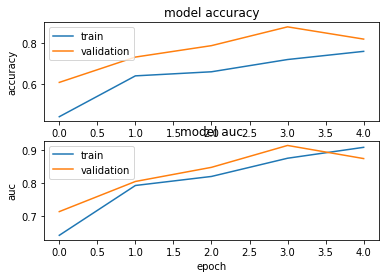

              precision    recall  f1-score   support

       Covid       0.47      0.59      0.52       111
      Normal       0.29      0.16      0.20        70
   Pneumonia       0.33      0.36      0.34        70

    accuracy                           0.40       251
   macro avg       0.36      0.37      0.36       251
weighted avg       0.38      0.40      0.38       251

[[65 17 29]
 [37 11 22]
 [35 10 25]]


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy

#Construct an ImageDataGenerator object:
DIRECTORY = "Covid19-dataset/train"
CLASS_MODE = "categorical"
COLOR_MODE = "grayscale"
TARGET_SIZE = (256,256)
BATCH_SIZE = 32

training_data_generator = ImageDataGenerator(rescale=1.0/255,

#Randomly increase or decrease the size of the image by up to 10%
zoom_range=0.1, 

#Randomly rotate the image between -25,25 degrees
rotation_range=25, 

#Shift the image along its width by up to +/- 5%
width_shift_range=0.05, 

#Shift the image along its height by up to +/- 5%
height_shift_range=0.05,

)

validation_data_generator = ImageDataGenerator()

training_iterator = training_data_generator.flow_from_directory(DIRECTORY,class_mode='categorical',color_mode='grayscale',batch_size=BATCH_SIZE)#, subset='training')

training_iterator.next()

print("\nLoading validation data...")


validation_iterator = validation_data_generator.flow_from_directory(DIRECTORY,class_mode='categorical', color_mode='grayscale',batch_size=BATCH_SIZE)#, subset='validation')

#Print its attributes:
# print(training_data_generator.__dict__)


print("\nBuilding model...")

def design_model(training_data):
    # sequential model
    model = Sequential()
    # add input layer with grayscale image shape
    model.add(tf.keras.Input(shape=(256, 256, 1)))
    # convolutional hidden layers with relu functions
    # maxpooling layers and dropout layers as well
    model.add(layers.Conv2D(5, 5, strides=3, activation="relu")) 
    model.add(layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2,2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(3, 3, strides=1, activation="relu")) 
    model.add(layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2,2)))
    model.add(layers.Dropout(0.2))

    # experimenting with extra layesr
    #model.add(tf.keras.layers.Conv2D(3, 3, strides=1, activation="relu"))
    #model.add(tf.keras.layers.Conv2D(1, 1, strides=1, activation="relu"))
    #model.add(tf.keras.layers.Dropout(0.1))

    model.add(layers.Flatten())
    # output layer with softmax activation function
    model.add(layers.Dense(3,activation="softmax"))
    # compile model with Adam optimizer
    # loss function is categorical crossentropy
    # metrics are categorical accuracy and AUC
    print("\nCompiling model...")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()],)
    # summarize model
    model.summary()
    return model

# use model function
model = design_model(training_iterator)

# early stopping implementation
es = EarlyStopping(monitor='val_auc', mode='min', verbose=1, patience=20)

print("\nTraining model...")
# fit the model with 10 ephochs and early stopping
history =model.fit(
        training_iterator,
        steps_per_epoch=training_iterator.samples/BATCH_SIZE, epochs=5,
        validation_data=validation_iterator,
        validation_steps=validation_iterator.samples/BATCH_SIZE,
        callbacks=[es])


# plotting categorical and validation accuracy over epochs
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['auc'])
ax2.plot(history.history['val_auc'])
ax2.set_title('model auc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')

plt.show()



test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predictions = model.predict(validation_iterator, steps=test_steps_per_epoch)
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predicted_classes = numpy.argmax(predictions, axis=1)
true_classes = validation_iterator.classes
class_labels = list(validation_iterator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

cm=confusion_matrix(true_classes,predicted_classes)
print(cm)





